In [ ]:
# 1 «Звёздные войны». Сохраните файл в формате YAML.
import requests
import yaml

# Функция для получения данных по URL
def get_data(url):
    response = requests.get(url)
    response.raise_for_status()  # Проверка на ошибки HTTP
    return response.json()

# Индексы персонажей, которые нужно загрузить
character_ids = [1, 2, 3]

# Словарь для хранения информации о персонажах
characters = {}

# Загружаем информацию о каждом персонаже
for char_id in character_ids:
    char_url = f'https://swapi.dev/api/people/{char_id}/'
    char_data = get_data(char_url)
    
    # Заменяем ссылки на фильмы на фактические объекты фильмов
    films = []
    for film_url in char_data['films']:
        film_data = get_data(film_url)
        films.append(film_data)
    
    # Обновляем данные персонажа
    char_data['films'] = films
    characters[char_id] = char_data

# Сохраняем данные в формате YAML
with open('star_wars_characters.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(characters, file, allow_unicode=True, sort_keys=False)

print("Данные успешно сохранены в star_wars_characters.yaml") # получается неожиданно большой файл, не уверен, что все корректно сохранил, но в задании нет уточнений по этому поводу


Данные успешно сохранены в star_wars_characters.yaml


In [5]:
# 2 server.json Прочитайте файл и внесите изменения.
import json
import yaml
import re


filepath = r'servers.json'
# Функция для замены хоста верхнего уровня
def replace_host(url):
    return url.replace('cloud.org', 'newcloud.com')

# Функция для замены имени сервера (host[0-9]+ на prod[0-9]+)
def replace_server_name(name):
    match = re.match(r'host(\d+)', name)
    if match:
        number = match.group(1)
        return f'prod{number}'
    return name

# Чтение файла server.json
with open(filepath, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Добавление нового сервера
new_server = {
    "name": "",
    "ip": "",
    "user": "admin"
}
data["new_server"] = new_server # метод не подходит для словаря, необходимо заменить

# Внесение изменений в данные
for server in data:
    # Замена хоста верхнего уровня
    if 'url' in server:
        server['url'] = replace_host(server['url'])
    
    # Замена имени сервера
    if 'name' in server:
        server['name'] = replace_server_name(server['name'])
    
    # Замена пользователя root на admin
    if 'user' in server and server['user'] == 'root':
        server['user'] = 'admin'

# Сохранение данных в формате YAML
with open('server.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(data, file, allow_unicode=True, sort_keys=False)

print("Файл успешно сохранён в формате YAML.")

TypeError: string indices must be integers, not 'str'

Топ-5 пользователей: [('root', 370), ('uucp', 5), ('ftp', 3), ('git', 3), ('sshd', 2)]
Топ-5 IP-адресов: [('183.62.140.253', 277), ('187.141.143.180', 51), ('112.95.230.3', 24), ('103.99.0.122', 11), ('123.235.32.19', 7)]
Топ-5 подсетей: [('183.62.x.x', 277), ('187.141.x.x', 51), ('112.95.x.x', 24), ('103.99.x.x', 11), ('123.235.x.x', 7)]


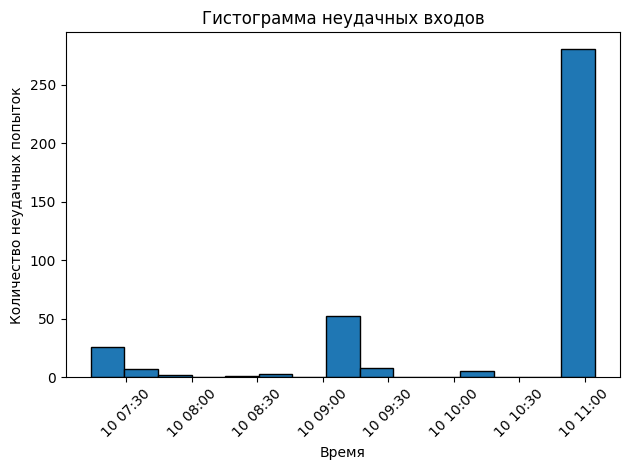

In [ ]:
# 3 файл с логами sshd. Постройте гистограмму неудачных входов в зависимости от времени, с размером корзины 5–10 минут.
import re
from collections import Counter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Загружаем файл
with open('ssh_2k.log', 'r') as file:
    logs = file.readlines()

# Регулярное выражение для поиска строк
pattern = r'Failed password for (\w+) from (\d+\.\d+\.\d+\.\d+) port \d+ ssh2'

# Списки для хранения данных
users = []
ips = []
timestamps = []

# Обрабатываем каждую строку логов
for log in logs:
    match = re.search(pattern, log)
    if match:
        users.append(match.group(1))  # Имя пользователя
        ips.append(match.group(2))    # IP-адрес
        # Извлекаем дату и время из лога
        timestamp_str = ' '.join(log.split()[:3])  # Первые три элемента: месяц, день, время
        timestamps.append(timestamp_str)

# Топ-5 пользователей
top_users = Counter(users).most_common(5)
print("Топ-5 пользователей:", top_users)

# Топ-5 IP-адресов
top_ips = Counter(ips).most_common(5)
print("Топ-5 IP-адресов:", top_ips)

# Топ-5 подсетей (первые 16 бит)
subnets = ['.'.join(ip.split('.')[:2]) + '.x.x' for ip in ips]
top_subnets = Counter(subnets).most_common(5)
print("Топ-5 подсетей:", top_subnets)

# Преобразуем временные метки в объекты datetime
# Добавляем текущий год, так как он не указан в логах
current_year = datetime.now().year
times = [datetime.strptime(f"{current_year} {ts}", '%Y %b %d %H:%M:%S') for ts in timestamps]

# Создаем список временных интервалов (корзин)
time_bins = []
current_time = min(times)
while current_time <= max(times):
    time_bins.append(current_time)
    current_time += timedelta(minutes=5)  # Интервал 5 минут

# Рассчитываем интервал между корзинами
time_range = max(times) - min(times)
num_bins = 15  # Задаём желаемое количество корзин (например, 15)
bin_interval = time_range / num_bins  # Интервал между корзинами

# Создаем список временных интервалов (корзин)
time_bins = [min(times) + i * bin_interval for i in range(num_bins + 1)]

# Строим гистограмму
plt.hist(times, bins=time_bins, edgecolor='black')
plt.xlabel('Время')
plt.ylabel('Количество неудачных попыток')
plt.title('Гистограмма неудачных входов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# 4 файл Is.txt c помощью регулярных выражений посчитайте суммарный размер файлов
import re
from datetime import datetime

# преобразование размера файла в байты
def convert_size_to_bytes(size_str):
    size_str = size_str.strip()
    if size_str.endswith('K'):
        return int(float(size_str[:-1]) * 1024)
    elif size_str.endswith('M'):
        return int(float(size_str[:-1]) * 1024 * 1024)
    else:
        return int(size_str)

# Чтение файла с данными
with open('ls.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

total_size = 0
prod_size = 0
stage_size = 0
dev_size = 0
dates = []
users = set()
groups = set()

# Регулярное выражение для разбора строки
pattern = re.compile(
    r'^[-d]([-rwx]{9})\s+\d+\s+(\S+)\s+(\S+)\s+([\dKM]+)\s+(\w{3}\s+\d{1,2}\s+(?:\d{2}:\d{2}|\d{4}))\s+(.+)$'
) # this is адская хреновина - удалить коммент перед отправкой

for line in lines:
    match = pattern.match(line)
    if match:
        # Извлечение данных из строки
        permissions, user, group, size_str, date_str, filename = match.groups()
        size = convert_size_to_bytes(size_str)  # Преобразование размера в байты
        total_size += size

        # Проверка наличия ключевых слов в имени файла
        if 'prod' in filename:
            prod_size += size
        elif 'stage' in filename:
            stage_size += size
        elif 'dev' in filename:
            dev_size += size

        # Обработка даты
        try:
            # Если дата содержит время (например, "Oct 10 12:34")
            date = datetime.strptime(date_str, '%b %d %H:%M')
        except ValueError:
            # Если дата содержит год (например, "Oct 10 2023")
            date = datetime.strptime(date_str, '%b %d %Y')

        dates.append(date)

        # Добавление пользователя и группы в множества
        users.add(user)
        groups.add(group)

# Вывод результатов
print(f"Суммарный размер всех файлов: {total_size} байт")
print(f"Размер файлов с 'prod': {prod_size} байт")
print(f"Размер файлов с 'stage': {stage_size} байт")
print(f"Размер файлов с 'dev': {dev_size} байт")

if dates:
    earliest_date = min(dates)
    latest_date = max(dates)
    print(f"Самая ранняя дата изменения: {earliest_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"Последняя дата изменения: {latest_date.strftime('%Y-%m-%d %H:%M')}")

print("Список пользователей:", ', '.join(sorted(users)))
print("Список групп:", ', '.join(sorted(groups)))

Суммарный размер всех файлов: 295698560 байт
Размер файлов с 'prod': 221249536 байт
Размер файлов с 'stage': 74448974 байт
Размер файлов с 'dev': 0 байт
Самая ранняя дата изменения: 1900-02-28 10:49
Последняя дата изменения: 1900-10-27 20:37
Список пользователей: root
Список групп: root


In [ ]:
# 5 база данных в архиве. Выведите список всех клиентов, которые проживают в городе, начинающемся на букву А
import sqlite3

# Подключение к базе данных, создание курсора
conn = sqlite3.connect('chinook.db')
cursor = conn.cursor()

# 1. Вывод списка таблиц в базе данных
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Список таблиц в базе данных:")
for table in tables:
    print(table[0])

# 2. Вывод списка всех сотрудников
cursor.execute("SELECT FirstName, LastName FROM employees;")
employees = cursor.fetchall()
print("\nСписок всех сотрудников:")
for employee in employees:
    print(f"{employee[0]} {employee[1]}")

# 3. Вывод списка городов, в которых проживают клиенты
cursor.execute("SELECT DISTINCT City FROM customers ORDER BY City;")
cities = cursor.fetchall()
print("\nСписок городов, в которых проживают клиенты:")
for city in cities:
    print(city[0])

# 4. Вывод списка всех клиентов, проживающих в городах, начинающихся на букву 'S'
cursor.execute("SELECT FirstName, LastName, City FROM customers WHERE City LIKE 'S%';") #Для проверки корректности работы изменено на "S", таких городов в базе больше
customers_a = cursor.fetchall()
print("\nСписок клиентов, проживающих в городах, начинающихся на букву 'S':")
for customer in customers_a:
    print(f"{customer[0]} {customer[1]} - {customer[2]}")

# Закрытие соединения с базой данных
conn.close()

Список таблиц в базе данных:
albums
sqlite_sequence
artists
customers
employees
genres
invoices
invoice_items
media_types
playlists
playlist_track
tracks
sqlite_stat1

Список всех сотрудников:
Andrew Adams
Nancy Edwards
Jane Peacock
Margaret Park
Steve Johnson
Michael Mitchell
Robert King
Laura Callahan

Список городов, в которых проживают клиенты:
Amsterdam
Bangalore
Berlin
Bordeaux
Boston
Brasília
Brussels
Budapest
Buenos Aires
Chicago
Copenhagen
Cupertino
Delhi
Dijon
Dublin
Edinburgh 
Edmonton
Fort Worth
Frankfurt
Halifax
Helsinki
Lisbon
London
Lyon
Madison
Madrid
Montréal
Mountain View
New York
Orlando
Oslo
Ottawa
Paris
Porto
Prague
Redmond
Reno
Rio de Janeiro
Rome
Salt Lake City
Santiago
Sidney
Stockholm
Stuttgart
São José dos Campos
São Paulo
Toronto
Tucson
Vancouver
Vienne
Warsaw
Winnipeg
Yellowknife

Список клиентов, проживающих в городах, начинающихся на букву 'S':
Luís Gonçalves - São José dos Campos
Leonie Köhler - Stuttgart
Eduardo Martins - São Paulo
Alexandre Rocha - São 

In [ ]:
# 6 Воспользуйтесь кодом из раздела «Рекомендация» для создания базы данных taxis.sqlite3.
